# imports

In [50]:
import pandas as pd
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
# import seaborn as sns; sns.set_theme(font='Malgun Gothic')

# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'max_colwidth', None)
import warnings; warnings.filterwarnings(action='ignore')

# 숫자 잘린거 다 보여주기
pd.options.display.float_format = '{:.5f}'.format

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

In [51]:
import statsmodels
statsmodels.__version__ # 0.12.2

'0.12.2'

# read

In [52]:
df = pd.read_csv('./hangseng.csv')

# ARIMA

In [53]:
df['Change']    = df['Close'].pct_change()
df['STDEV']     = df['Close'].rolling(window=20).std(ddof=0)
df['STDEV_log'] = np.log(df['Close'].rolling(window=20).std(ddof=0))
df['HV']        = df['Change'].rolling(window=20, center=False).std() * (252 ** 0.5)

In [54]:
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,Change,STDEV_log,STDEV
4642,2021-11-08,24837.76953,24633.57031,24743.53906,24763.76953,1762623700.00000,24763.76953,-0.00429,6.11713,0.16193
4643,2021-11-09,24956.36914,24678.66016,24952.82031,24813.13086,1154696200.00000,24813.13086,0.00199,6.12080,0.16087
4644,2021-11-10,25013.10938,24481.25977,24787.43945,24996.14062,1688052600.00000,24996.14062,0.00738,6.14180,0.14628
4645,2021-11-11,25324.66016,24836.21094,24856.10938,25247.99023,2001862500.00000,25247.99023,0.01008,6.11991,0.14152
4646,2021-11-12,25527.13086,25210.56055,25522.83008,25327.97070,1632112200.00000,25327.97070,0.00317,6.11998,0.13180


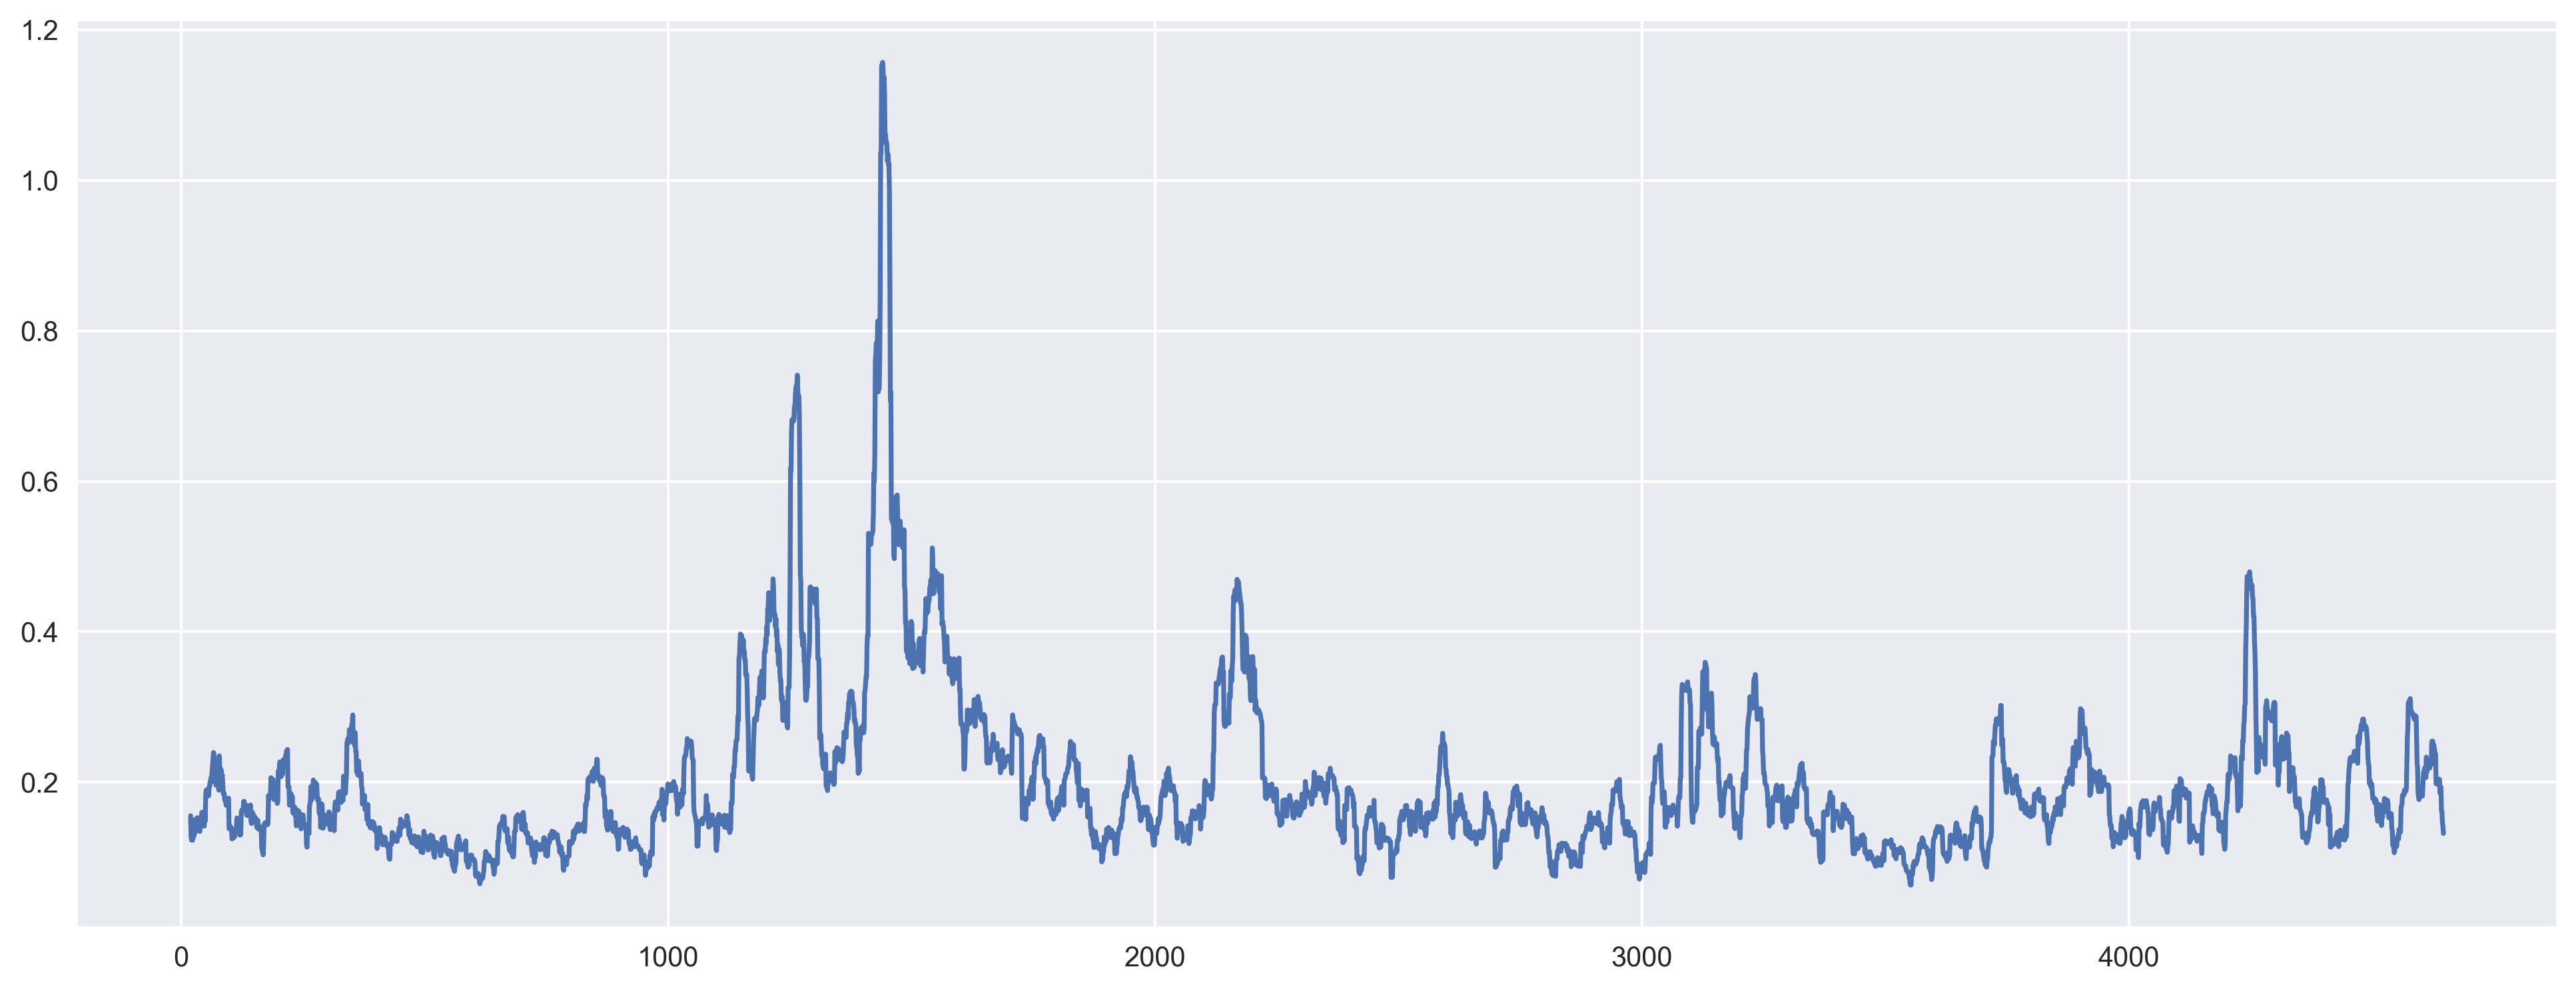

In [55]:
plt.figure(figsize=(16,6))
df['STDEV'].plot() # STDEV_log, HV
plt.show()

In [56]:
# nan 값 삭제
df = df.dropna()

In [57]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Change,STDEV_log,STDEV
20,2003-01-30,9266.15039,9179.24023,9251.94043,9258.95020,151874200.00000,9258.95020,0.00197,5.19901,0.15532
21,2003-02-04,9331.95020,9208.23047,9327.32031,9252.70996,157056000.00000,9252.70996,-0.00067,5.27320,0.12730
22,2003-02-05,9238.91992,9156.30957,9214.63965,9180.46973,156418400.00000,9180.46973,-0.00781,5.35162,0.12294
23,2003-02-06,9184.75977,9094.86035,9178.25977,9126.15039,191530600.00000,9126.15039,-0.00592,5.42908,0.12342
24,2003-02-07,9163.66992,9072.66992,9099.41016,9150.95020,153250800.00000,9150.95020,0.00272,5.47110,0.12278


In [58]:
close_df = df[['Date','STDEV']]
# close_df = df[['Date','STDEV_log']]
# close_df = df[['Date','HV']]

close_df = close_df.sort_values('Date')
close_df = close_df.set_index('Date')

In [59]:
train_df = close_df.loc['2003-09-29':'2020-09-28']    # 2003-9-29 ~ 2020-9-28
test_df = close_df.loc['2020-09-29':'2021-09-28']  # 2020-9-29 ~ 2021-9-28

In [60]:
train_df.tail()

,STDEV
Date,
2020-09-22,0.12152
2020-09-23,0.12191
2020-09-24,0.13171
2020-09-25,0.12682
2020-09-28,0.13554


In [61]:
test_df.tail()

,STDEV
Date,
2021-09-21,0.21325
2021-09-23,0.21968
2021-09-24,0.22094
2021-09-27,0.22109
2021-09-28,0.22548


# Auto Arima

In [62]:
model_arima= auto_arima(train_df, trace=True, error_action='ignore', start_p=1, start_q=1, max_p=4, max_q=4)
model_arima.fit(train_df)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-23774.283, Time=2.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23755.280, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23783.467, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23776.924, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23757.278, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23858.801, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-23894.902, Time=0.38 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-23893.940, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-23892.651, Time=0.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-23877.314, Time=1.63 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-23891.927, Time=0.57 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-23896.902, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-23860.801, Time=0.34 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-23895.940, Time=0.35 sec
 ARIM

ARIMA(order=(3, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [63]:
tmp_dict = model_arima.to_dict()
tmp_dict['order']

(3, 1, 0)

In [64]:
adfsdfsdf

NameError: name 'adfsdfsdf' is not defined

# ARIMA

In [65]:
model = ARIMA(train_df, order=(3,1,0))

arima_res = model.fit(trend='c', full_output=True, disp=1)
print(arima_res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.STDEV   No. Observations:                 4187
Model:                 ARIMA(3, 1, 0)   Log Likelihood               11952.451
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 15 Nov 2021   AIC                         -23894.903
Time:                        20:16:18   BIC                         -23863.204
Sample:                             1   HQIC                        -23883.693
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.473e-06      0.000     -0.028      0.978      -0.001       0.001
ar.L1.D.STDEV     0.0604      0.015      3.927      0.000       0.030       0.091
ar.L2.D.STDEV     0.1283      0.015     

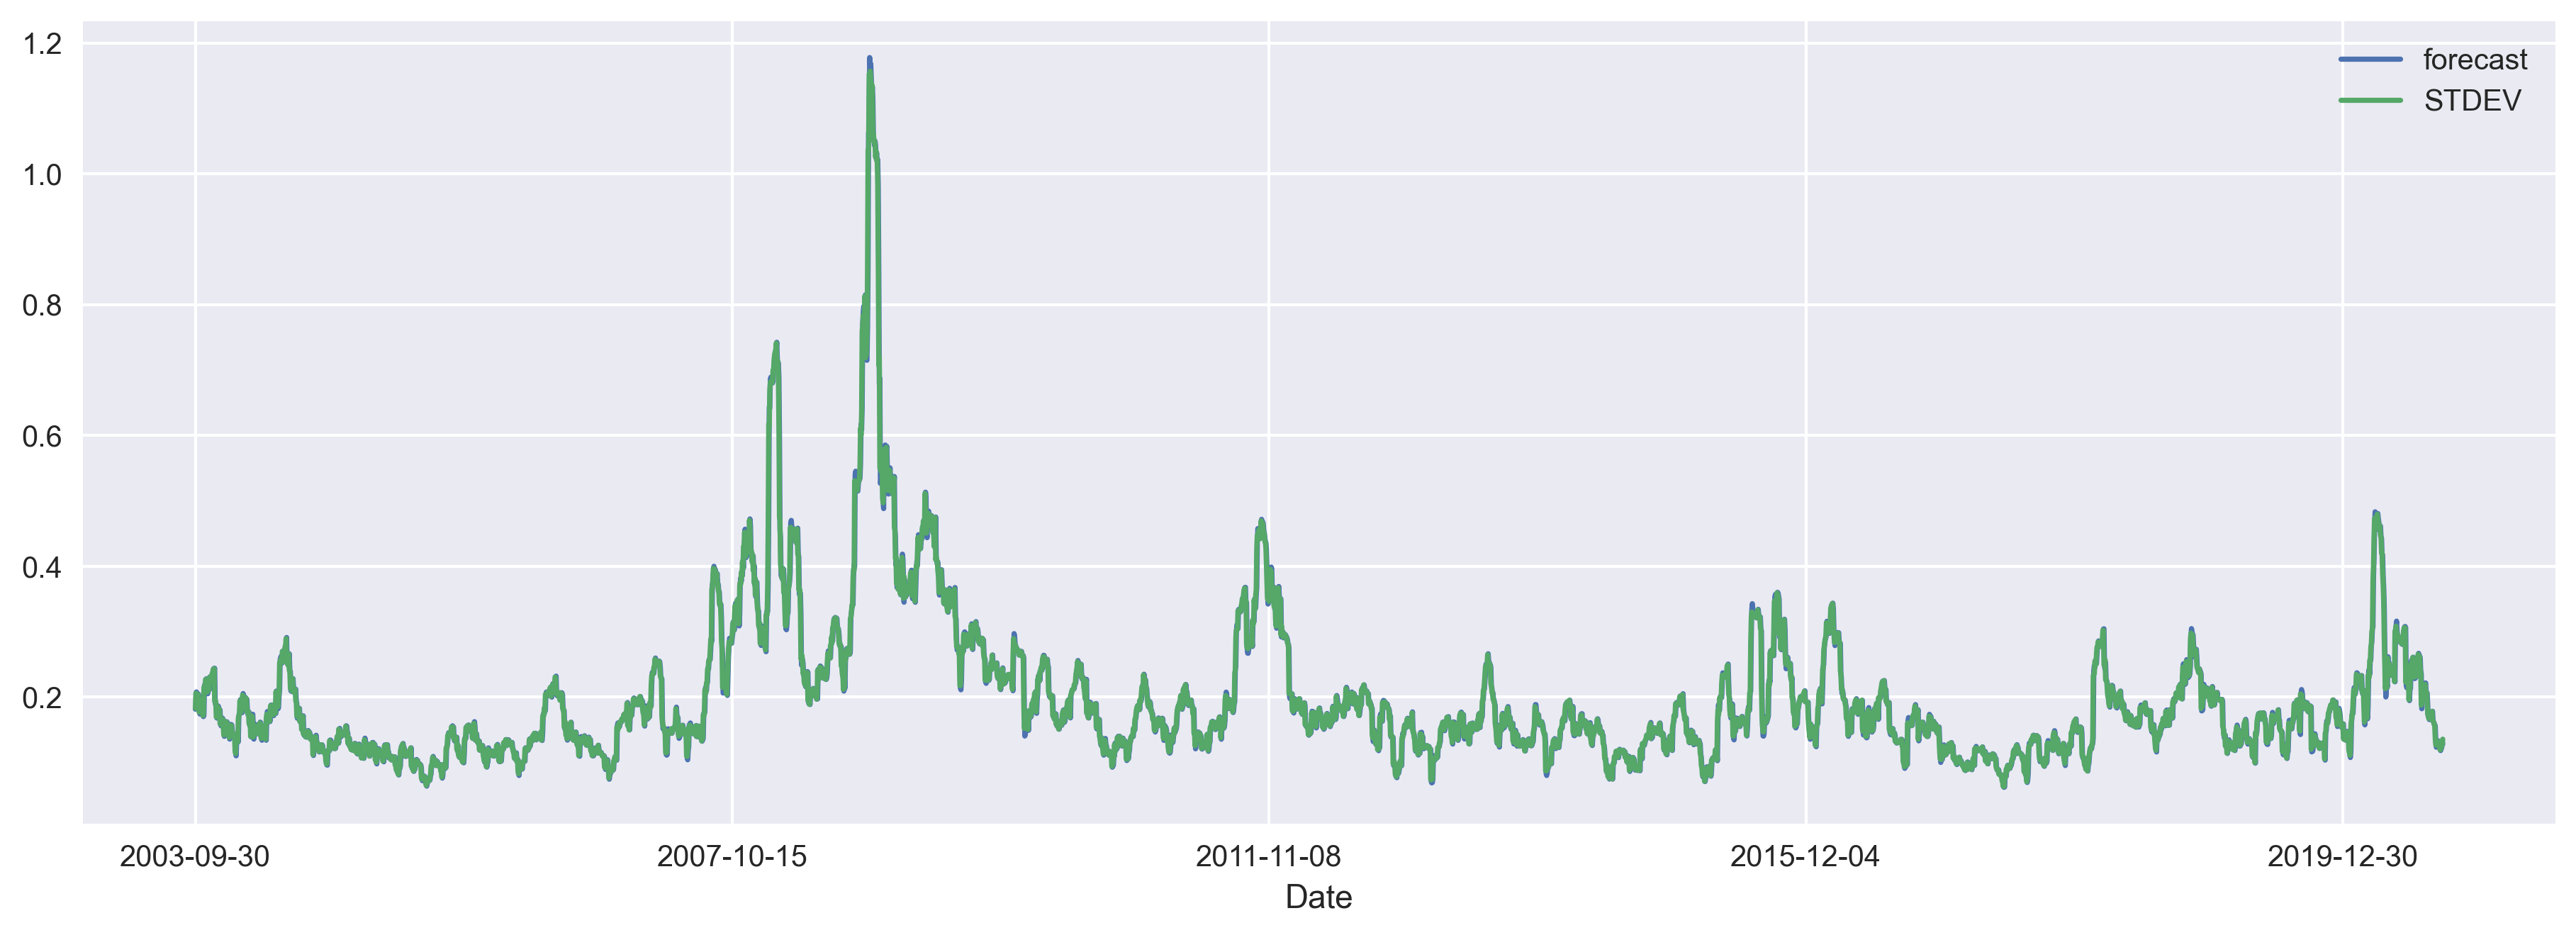

In [66]:
pig, ax = plt.subplots(figsize=(15,5))
arima_res.plot_predict(ax=ax)
plt.show()

# 1년치(2020-9-29 ~ 2021-9-28) 맞추기

In [67]:
forcast_result = arima_res.forecast(steps=246) # 245: 245일 맞춰봐 
# 예측값, stderr,   upper bound~lower bound
forcast_result = forcast_result[0]
print(forcast_result)

[0.13636977 0.13706778 0.13804029 0.13826116 0.13845965 0.13858647
 0.13863456 0.13866656 0.13868066 0.13868413 0.13868313 0.13867879
 0.13867266 0.13866557 0.13865787 0.13864985 0.13864163 0.13863331
 0.13862492 0.13861649 0.13860805 0.13859959 0.13859113 0.13858266
 0.13857419 0.13856572 0.13855725 0.13854877 0.1385403  0.13853183
 0.13852336 0.13851488 0.13850641 0.13849794 0.13848946 0.13848099
 0.13847252 0.13846404 0.13845557 0.1384471  0.13843863 0.13843015
 0.13842168 0.13841321 0.13840473 0.13839626 0.13838779 0.13837931
 0.13837084 0.13836237 0.13835389 0.13834542 0.13833695 0.13832848
 0.13832    0.13831153 0.13830306 0.13829458 0.13828611 0.13827764
 0.13826916 0.13826069 0.13825222 0.13824375 0.13823527 0.1382268
 0.13821833 0.13820985 0.13820138 0.13819291 0.13818443 0.13817596
 0.13816749 0.13815902 0.13815054 0.13814207 0.1381336  0.13812512
 0.13811665 0.13810818 0.1380997  0.13809123 0.13808276 0.13807428
 0.13806581 0.13805734 0.13804887 0.13804039 0.13803192 0.13802

In [68]:
len(forcast_result)

246

In [69]:
real = np.array(test_df['STDEV'])
real

array([0.13592237, 0.14219967, 0.15370531, 0.15406667, 0.1596856 ,
       0.15956159, 0.15849679, 0.17600134, 0.17401725, 0.1879385 ,
       0.19088073, 0.1925    , 0.18387457, 0.18499202, 0.16698748,
       0.16167815, 0.1639919 , 0.14703295, 0.14810419, 0.16502389,
       0.16702955, 0.17690483, 0.17370282, 0.20324291, 0.20154821,
       0.20291343, 0.20280584, 0.19318315, 0.19394854, 0.1734751 ,
       0.17314828, 0.17316648, 0.17292518, 0.17661043, 0.17646781,
       0.17643226, 0.17362551, 0.17182067, 0.16868568, 0.1434723 ,
       0.16641457, 0.15681303, 0.15646486, 0.11363533, 0.11373751,
       0.11867387, 0.11621413, 0.11862939, 0.11911045, 0.119554  ,
       0.11702502, 0.11945956, 0.12337254, 0.12393024, 0.12606975,
       0.12862746, 0.12981463, 0.13344035, 0.13173047, 0.13119573,
       0.11435534, 0.13459464, 0.13444799, 0.13543837, 0.13632912,
       0.12623934, 0.12399139, 0.12740399, 0.12555008, 0.13088647,
       0.12900962, 0.12453311, 0.12294895, 0.12400316, 0.14190

In [70]:
len(real)

246

# RMSE 확인

In [71]:
from sklearn.metrics import mean_squared_error

mean_squared_error(real, forcast_result, squared=False)

0.0726712019855618